tgb - 3/4/2020 - Cleaning up the code for the non-linear ACnet developed in notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/035_RH_layers.ipynb]. Includes:  
- Moist thermodynamics libraries in both tensorflow and numpy  
- Code to build & train non-linear UCnet and ACnet  
- Diagnostics of non-linear UCnet/ACnet's performances & energy/mass conservation

# 0) Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W0305 01:13:51.500417 23432513247040 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0305 01:13:51.501419 23432513247040 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W0305 01:13:51.501970 23432513247040 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Tensorflow library

## 1.1) Moist thermodynamics

In [2]:
# Moist thermodynamics library adapted to tf
def eliq(T):
    a_liq = np.float32(np.array([-0.976195544e-15,-0.952447341e-13,\
                                 0.640689451e-10,\
                      0.206739458e-7,0.302950461e-5,0.264847430e-3,\
                      0.142986287e-1,0.443987641,6.11239921]));
    c_liq = np.float32(-80.0)
    T0 = np.float32(273.16)
    return np.float32(100.0)*tfm.polyval(a_liq,tfm.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.float32(np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,\
                      0.602588177e-7,0.615021634e-5,0.420895665e-3,\
                      0.188439774e-1,0.503160820,6.11147274]));
    c_ice = np.float32(np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07]))
    T0 = np.float32(273.16)
    return tf.where(T>c_ice[0],eliq(T),\
                   tf.where(T<=c_ice[1],np.float32(100.0)*(c_ice[3]+tfm.maximum(c_ice[2],T-T0)*\
                   (c_ice[4]+tfm.maximum(c_ice[2],T-T0)*c_ice[5])),\
                           np.float32(100.0)*tfm.polyval(a_ice,T-T0)))

def esat(T):
    T0 = np.float32(273.16)
    T00 = np.float32(253.16)
    omtmp = (T-T00)/(T0-T00)
    omega = tfm.maximum(np.float32(0.0),tfm.minimum(np.float32(1.0),omtmp))

    return tf.where(T>T0,eliq(T),tf.where(T<T00,eice(T),(omega*eliq(T)+(1-omega)*eice(T))))

def qv(T,RH,P0,PS,hyam,hybm):
    
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    RH = tf.cast(RH,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return R*esat(T)*RH/(Rv*p)
    # DEBUG 1
    # return esat(T)
    
def RH(T,qv,P0,PS,hyam,hybm):
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    qv = tf.cast(qv,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return Rv*p*qv/(R*esat(T))

## 1.2) Conversion Layers

### 1.2.1) From relative to specific humidity (inputs)

In [3]:
class RH2QV(Layer):
    def __init__(self, inp_subQ, inp_divQ, inp_subRH, inp_divRH, hyam, hybm, **kwargs):
        """
        Call using ([input])
        Converts specific humidity to relative humidity and renormalizes all inputs
        in preparation for ACnet
        Assumes
        prior: [RHBP, 
        QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, 
        Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        Returns
        post(erior): [QBP, 
        QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, 
        Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        """
        self.inp_subQ, self.inp_divQ, self.inp_subRH, self.inp_divRH, self.hyam, self.hybm = \
            np.array(inp_subQ), np.array(inp_divQ), np.array(inp_subRH), np.array(inp_divRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(90,120)
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ),
                  'inp_subRH': list(self.inp_subRH), 'inp_divRH': list(self.inp_divRH),
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        prior = arrs
        
        # Denormalize T,RH,PS to get them in physical units
        Tprior = prior[:,self.TBP_idx]*self.inp_divRH[self.TBP_idx]+self.inp_subRH[self.TBP_idx]
        RHprior = prior[:,self.QBP_idx]*self.inp_divRH[self.QBP_idx]+self.inp_subRH[self.QBP_idx]
        PSprior = prior[:,self.PS_idx]*self.inp_divRH[self.PS_idx]+self.inp_subRH[self.PS_idx]
        
        # Calculate qv from RH,PS,T using moist thermo library & normalize
        qvprior = (qv(Tprior,RHprior,P0,PSprior,self.hyam,self.hybm)-\
                    self.inp_subQ[self.QBP_idx])/self.inp_divQ[self.QBP_idx]
        
        # Concatenate renormalized inputs to form final input vector
        post = tf.concat([tf.cast(qvprior,tf.float32),
                          ((prior[:,30:]*self.inp_divRH[30:]+self.inp_subRH[30:])\
                           -self.inp_subQ[30:])/self.inp_divQ[30:]\
                         ], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape + 1"""
        return (input_shape[0][0])

### 1.2.2) From specific to relative humidity time-tendency (output)

In [4]:
class dQVdt2dRHdt(Layer):
    def __init__(self, inp_subQ, inp_divQ, norm_qQ, norm_TQ, inp_subRH, inp_divRH, norm_qRH, hyam, hybm, **kwargs):
        """
        Call using ([input_qv,output])
        Converts specific humidity tendency output to relative humidity tendency output
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [dRHdt, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_subQ, self.inp_divQ, self.norm_qQ, self.norm_TQ, \
        self.inp_subRH, self.inp_divRH, self.norm_qRH, \
        self.hyam, self.hybm = \
            np.array(inp_subQ), np.array(inp_divQ), \
        np.array(norm_qQ), np.array(norm_TQ),\
        np.array(inp_subRH), np.array(inp_divRH), np.array(norm_qRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.PHQ_idx = slice(0,30)
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(90,120)
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ),
                  'norm_qQ': list(self.norm_qQ),'norm_TQ':list(self.norm_TQ),
                  'inp_subRH': list(self.inp_subRH), 'inp_divRH': list(self.inp_divRH),
                  'norm_qRH': list(self.norm_qRH), 
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        inp, prior = arrs
        
        # Denormalize specific humidity, temperature and surface pressure to convert them to physical units
        Qprior = inp[:,self.QBP_idx]*self.inp_divQ[self.QBP_idx]+self.inp_subQ[self.QBP_idx]
        Tprior = inp[:,self.TBP_idx]*self.inp_divQ[self.TBP_idx]+self.inp_subQ[self.TBP_idx]
        PSprior = inp[:,self.PS_idx]*self.inp_divQ[self.PS_idx]+self.inp_subQ[self.PS_idx]
        
        # Calculate specific humidity after physics using its time-tendency
        dqvdtprior = prior[:,self.QBP_idx]/self.norm_qQ
        Q2prior = Qprior+DT*dqvdtprior
        
        # Calculate temperature after physics using its time-tendency
        dTdtprior = prior[:,self.TBP_idx]/self.norm_TQ
        T2prior = Tprior+DT*dTdtprior
        
        # Infer the relative humidity tendency from relative humidity before & after physics
        RHprior = RH(Tprior,Qprior,P0,PSprior,self.hyam,self.hybm)
        RH2prior = RH(T2prior,Q2prior,P0,PSprior,self.hyam,self.hybm)
        dRHdtprior = ((RH2prior-RHprior)/DT)*self.norm_qRH
        
        # Concatenate the relative humidity tendency with the remaining outputs
        post = tf.concat([dRHdtprior,prior[:,30:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape"""
        return (input_shape[0][0],input_shape[0][1])

# 2) Build UCnet_NL and ACnet_NL

## 2.1) Generators

In [13]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [14]:
scale_dict['dRHdt'] = 5*L_S/G, # Factor 5 in loss to give std of dRH/dt similar weight as std of dT/dt

### 2.1.1) Generator using RH

In [15]:
in_vars = ['RH', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['dRHdt', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [16]:
TRAINFILE = '8col009RH_01_train.nc'
NORMFILE = '8col009RH_01_norm.nc'
VALIDFILE = '8col009RH_01_valid.nc'
TESTFILE = '8col009RH_01_test.nc'

In [17]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [18]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [19]:
test_gen = DataGenerator(
    data_fn = TRAINDIR+TESTFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

### 2.1.2) Generators using qv

In [20]:
TRAINFILEQ = '8col009_01_train.nc'
VALIDFILEQ = '8col009_01_valid.nc'
NORMFILEQ = '8col009_01_norm.nc'
TESTFILEQ = '8col009_01_test.nc'

In [21]:
scale_dictQ = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [22]:
in_varsQ = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_varsQ = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [23]:
train_genQ = DataGenerator(
    data_fn = TRAINDIR+TRAINFILEQ,
    input_vars = in_varsQ,
    output_vars = out_varsQ,
    norm_fn = TRAINDIR+NORMFILEQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dictQ,
    batch_size=1024,
    shuffle=True
)

In [24]:
valid_genQ = DataGenerator(
    data_fn = TRAINDIR+VALIDFILEQ,
    input_vars = in_varsQ,
    output_vars = out_varsQ,
    norm_fn = TRAINDIR+NORMFILEQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dictQ,
    batch_size=1024,
    shuffle=True
)

In [25]:
test_genQ = DataGenerator(
    data_fn = TRAINDIR+TESTFILEQ,
    input_vars = in_varsQ,
    output_vars = out_varsQ,
    norm_fn = TRAINDIR+NORMFILEQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dictQ,
    batch_size=1024,
    shuffle=True
)

## 2.2) Models

### 2.2.1) UCnet NL

In [7]:
inp = Input(shape=(304,))
inpQ = RH2QV(inp_subQ=train_genQ.input_transform.sub, 
             inp_divQ=train_genQ.input_transform.div, 
             inp_subRH=train_gen.input_transform.sub, 
             inp_divRH=train_gen.input_transform.div, 
             hyam=hyam, hybm=hybm)(inp)
densout = Dense(512, activation='linear')(inpQ)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
outQ = Dense(218, activation='linear')(densout)
out = dQVdt2dRHdt(inp_subQ=train_genQ.input_transform.sub,
                  inp_divQ=train_genQ.input_transform.div,
                  norm_qQ=scale_dictQ['PHQ'], 
                  inp_subRH=train_gen.input_transform.sub, 
                  inp_divRH=train_gen.input_transform.div, 
                  norm_qRH=scale_dict['dRHdt'], 
                  hyam=hyam, hybm=hybm)([inpQ, outQ])
UCnet_NL = tf.keras.models.Model(inp, out)

NameError: name 'train_genQ' is not defined

In [ ]:
name = 'UCnetNL_20'
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
UCnet_NL.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [ ]:
Nep = 10
UCnet_NL.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

### 2.2.2) ACnet NL

In [ ]:
inp = Input(shape=(304,))
inpQ = RH2QV(inp_subQ=train_genQ.input_transform.sub, 
             inp_divQ=train_genQ.input_transform.div, 
             inp_subRH=train_gen.input_transform.sub, 
             inp_divRH=train_gen.input_transform.div, 
             hyam=hyam, hybm=hybm)(inp)
densout = Dense(512, activation='linear')(inpQ)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
surfout = SurRadLayer(
    inp_div=train_genQ.input_transform.div,
    inp_sub=train_genQ.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, densout])
massout = MassConsLayer(
    inp_div=train_genQ.input_transform.div,
    inp_sub=train_genQ.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, surfout])
enthout = EntConsLayer(
    inp_div=train_genQ.input_transform.div,
    inp_sub=train_genQ.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, massout])
out = dQVdt2dRHdt(inp_subQ=train_genQ.input_transform.sub,
                  inp_divQ=train_genQ.input_transform.div,
                  norm_qQ=scale_dictQ['PHQ'],
                  norm_TQ=scale_dictQ['TPHYSTND'],
                  inp_subRH=train_gen.input_transform.sub, 
                  inp_divRH=train_gen.input_transform.div, 
                  norm_qRH=scale_dict['dRHdt'], 
                  hyam=hyam, hybm=hybm)([inpQ, enthout])
ACnet_NL = tf.keras.models.Model(inp, out)

In [ ]:
name = 'ACnetNL_20'
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
ACnet_NL.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [ ]:
Nep = 10
ACnet_NL.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

# 3) Numpy library

<a id='np_destination'></a>

## 3.1) Moist thermodynamics

In [7]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def deliqdT(T):
    a_liq = np.array([-0.599634321e-17,-0.792933209e-14,-0.604119582e-12,0.385208005e-9,0.103167413e-6,0.121167162e-4,0.794747212e-3,0.285976452e-1,0.443956472])
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def deicedT(T):
    a_ice = np.array([0.497275778e-16,0.390204672e-13,0.132073448e-10,0.255653718e-8,0.312668753e-6,0.249065913e-4,0.126710138e-2,0.377174432e-1,0.503223089])
    c_ice = np.array([273.15,185,-100,0.0013186,2.60269e-05,1.28676e-07])
    T0 = 273.16
    return (T>c_ice[0])*deliqdT(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    Bsize = np.shape(T)[0]
    p = np.tile(hyam*P0,(Bsize,1))+np.tile(hybm,(Bsize,1))*np.tile(PS,(30,1)).T
    return R*esat(T)*RH/(Rv*p)

## 3.2) Mass/Energy/Radiation checkers

In [8]:
def mass_res_diagno(inp_div,inp_sub,norm_q,inp,pred):
    # Input
    PS_idx = 300
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    PRECT_idx = 214
    PRECTEND_idx = 215

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute water integral
    WATINT = np.sum(dP_tilde *(pred[:, PHQ_idx] + pred[:, PHCLDLIQ_idx] + pred[:, PHCLDICE_idx]), axis=1)
#     print('PHQ',np.mean(np.sum(dP_tilde*pred[:,PHQ_idx],axis=1)))
#     print('PHCLQ',np.mean(np.sum(dP_tilde*pred[:,PHCLDLIQ_idx],axis=1)))
#     print('PHICE',np.mean(np.sum(dP_tilde*pred[:,PHCLDICE_idx],axis=1)))

    # 3. Compute latent heat flux and precipitation forcings
    LHFLX = inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + inp_sub[LHFLX_idx]
    PREC = pred[:, PRECT_idx] + pred[:, PRECTEND_idx]

    # 4. Compute water mass residual
#     print('LHFLX',np.mean(LHFLX))
#     print('PREC',np.mean(PREC))
#     print('WATINT',np.mean(WATINT))
    WATRES = LHFLX - PREC - WATINT
    #print('WATRES',np.mean(WATRES))

    return np.square(WATRES)

In [9]:
def ent_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300
    SHFLX_idx = 302
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    TPHYSTND_idx = slice(90, 120)
    DTVKE_idx = slice(180, 210)
    FSNT_idx = 210
    FSNS_idx = 211
    FLNT_idx = 212
    FLNS_idx = 213
    PRECT_idx = 214
    PRECTEND_idx = 215
    PRECST_idx = 216
    PRECSTEND_idx = 217

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute net energy input from phase change and precipitation
    PHAS = L_I / L_V * (
            (pred[:, PRECST_idx] + pred[:, PRECSTEND_idx]) -
            (pred[:, PRECT_idx] + pred[:, PRECTEND_idx])
    )

    # 3. Compute net energy input from radiation, SHFLX and TKE
    RAD = (pred[:, FSNT_idx] - pred[:, FSNS_idx] -
           pred[:, FLNT_idx] + pred[:, FLNS_idx])
    SHFLX = (inp[:, SHFLX_idx] * inp_div[SHFLX_idx] +
             inp_sub[SHFLX_idx])
    KEDINT = np.sum(dP_tilde * pred[:, DTVKE_idx], 1)

    # 4. Compute tendency of vapor due to phase change
    LHFLX = (inp[:, LHFLX_idx] * inp_div[LHFLX_idx] +
             inp_sub[LHFLX_idx])
    VAPINT = np.sum(dP_tilde * pred[:, PHQ_idx], 1)
    SPDQINT = (VAPINT - LHFLX) * L_S / L_V

    # 5. Same for cloud liquid water tendency
    SPDQCINT = np.sum(dP_tilde * pred[:, PHCLDLIQ_idx], 1) * L_I / L_V

    # 6. And the same for T but remember residual is still missing
    DTINT = np.sum(dP_tilde * pred[:, TPHYSTND_idx], 1)

    # 7. Compute enthalpy residual
    ENTRES = SPDQINT + SPDQCINT + DTINT - RAD - SHFLX - PHAS - KEDINT

    return np.square(ENTRES)

In [10]:
def lw_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300

    # Output
    QRL_idx = slice(120, 150)
    FLNS_idx = 213
    FLNT_idx = 212

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute longwave integral
    LWINT = np.sum(dP_tilde *pred[:, QRL_idx], axis=1)

    # 3. Compute net longwave flux from lw fluxes at top and bottom
    LWNET = pred[:, FLNS_idx] - pred[:, FLNT_idx]

    # 4. Compute water mass residual
    LWRES = LWINT-LWNET

    return np.square(LWRES)

def sw_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300

    # Output
    QRS_idx = slice(150, 180)
    FSNS_idx = 211
    FSNT_idx = 210

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute longwave integral
    SWINT = np.sum(dP_tilde *pred[:, QRS_idx], axis=1)

    # 3. Compute net longwave flux from lw fluxes at top and bottom
    SWNET = pred[:, FSNT_idx] - pred[:, FSNS_idx]

    # 4. Compute water mass residual
    SWRES = SWINT-SWNET

    return np.square(SWRES)

In [11]:
def tot_res_diagno(inp_div,inp_sub,norm_q,inp,pred):
    return 0.25*(mass_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                ent_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                lw_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                sw_res_diagno(inp_div,inp_sub,norm_q,inp,pred))

[Link to diagnostics](#diagnostics)

# 4) Diagnostics

## 4.1) Load models

In [5]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5']
NNname = ['UCnet','UCnet_{NL}','ACnet_{NL}'] # TODO: Add UCnet_NL
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'RH2QV':RH2QV,'dQVdt2dRHdt':dQVdt2dRHdt,
           'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH}

In [6]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)

W0305 01:14:03.310660 23432513247040 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0305 01:14:03.311561 23432513247040 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0305 01:14:03.312589 23432513247040 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  035_UCnet.hdf5
NN name is  UCnetNL_10.hdf5


W0305 01:14:04.717222 23432513247040 deprecation.py:323] From <ipython-input-2-d8b861a31dd8>:20: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


NN name is  ACnetNL_10.hdf5


## 4.2) Calculate square error and physical constraints residual

[Link to numpy library for diagnostics](#np_destination)

<a id='diagnostics'></a>

In [26]:
gen = valid_gen
genQ = valid_genQ

In [27]:
# SE = {}
# TRES = {}

# for iNNs,NNs in enumerate(['UCnetNL_10.hdf5','ACnetNL_10.hdf5']):
#     SE[NNs] = np.zeros((1,218))
#     TRES[NNs] = np.zeros((1,))

In [28]:
SE = {}
TRES = {}
MSE = {}

In [ ]:
spl = 0
while gen[spl][0].size>0: #spl is sample number
    
    print('spl=',spl,'                  ',end='\r')
    
    inp = gen[spl][0]
    truth = gen[spl][1]
    
    inp_phys = inp*gen.input_transform.div+gen.input_transform.sub
    
    for iNNs,NNs in enumerate(['UCnetNL_10.hdf5','ACnetNL_10.hdf5']):
        
        pred = NN[NNs].predict_on_batch(inp)

        se = (pred-truth)**2

        pred_phys = pred/gen.output_transform.scale

        QV1 = qv(inp_phys[:,90:120],inp_phys[:,:30],P0,inp_phys[:,300],hyam,hybm)
        QV2 = qv(inp_phys[:,90:120]+DT*pred_phys[:,90:120],
                 inp_phys[:,:30]+DT*pred_phys[:,:30],P0,inp_phys[:,300],hyam,hybm)
        dQVdt = train_genQ.output_transform.scale[:30]*(QV2-QV1)/DT

        predQ = np.copy(pred)
        predQ[:,:30] = dQVdt

        tresid = tot_res_diagno(gen.input_transform.div,gen.input_transform.sub,
                                genQ.output_transform.scale[:30],inp,predQ)
        
        if spl==0: SE[NNs] = se; TRES[NNs] = tresid; MSE[NNs] = np.mean(se);
        else: SE[NNs] += se; TRES[NNs] += tresid; MSE[NNs] += np.mean(se);
        
    spl += 1
    
for iNNs,NNs in enumerate(['UCnetNL_10.hdf5','ACnetNL_10.hdf5']):
    TRES[NNs] /= spl; MSE[NNs] /= spl; SE[NNs] /= spl

In [45]:
# for iNNs,NNs in enumerate(['UCnetNL_10.hdf5','ACnetNL_10.hdf5']):
#     SE[NNs] = SE[NNs][1:,:]
#     TRES[NNs] = TRES[NNs][1:,]

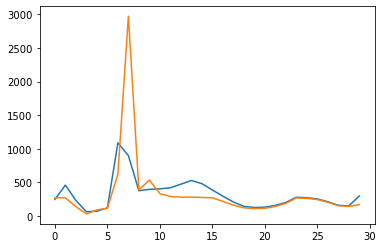

In [93]:
plt.plot(np.mean(SE['ACnetNL_10.hdf5'][:,:30],axis=0))
plt.plot(np.mean(SE['UCnetNL_10.hdf5'][:,:30],axis=0))
plt.plot(np.mean(SE['035_UCnet.hdf5'][:,:30],axis=0))

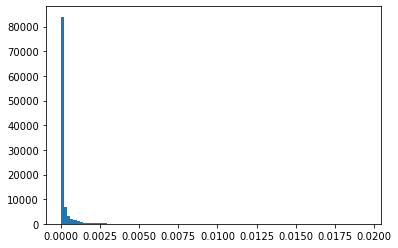

In [54]:
plt.hist(TRES['ACnetNL_10.hdf5'],bins=100);

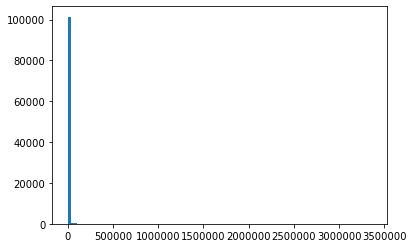

In [55]:
plt.hist(TRES['UCnetNL_10.hdf5'],bins=100);

In [57]:
np.mean(TRES['ACnetNL_10.hdf5']),np.std(TRES['ACnetNL_10.hdf5'])

(0.00018497690210733377, 0.0005742625048286946)

In [58]:
np.mean(TRES['UCnetNL_10.hdf5']),np.std(TRES['UCnetNL_10.hdf5'])

(4179.031610499942, 53749.56741219844)

## 4.3) Save reduced data in PKL format

In [92]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [94]:
hf = open(pathPKL+'2020_03_04_validgen041.pkl','wb')
S = {"TRES":TRES,"MSE":MSE,"SE":SE}
pickle.dump(S,hf)
hf.close()